# How Do You Say "GIF"?

The goal of this project was to build a classification model to predict how individuals pronounced GIF (i.e., with a hard "g", like "gift"; with a soft "g", like "jiff"; or some other way) using responses from the 2017 StackOverflow Developers Survey. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import Imputer
import re

import pickle

%matplotlib inline

In [2]:
# load data
data = pd.read_csv('./Data/developer_survey_2017/survey_results_public.csv')

### Data Wrangling and Feature Engineering

Most of the survey responses were multiple choice, resulting in categorical features. In order to fit classification models using the data, at a minimum all the responses need to be converted into dummy variables. As a first pass, I did just this: I converted all features into dummy variables and ran a random forest model. However, the random forest metrics showed poorer performance than the base model. 

In attempt to try to optimize the model, I tried feature engineering. The feature engineering and model fitting steps were iterated.

- Where possible, I tried to create continuous features (i.e., features involving years and time).
- After examining each survey question and response, I tried to think of ways to generate new features that would be associated with the target variable.

In [70]:
# remove rows without GIF answers
data = data.loc[pd.notnull(data.PronounceGIF),:]
data.reset_index(inplace=True)

In [99]:
# pickle for future use
# remove Respondent column
pickle.dump(data.iloc[:,1:], open("data.pkl", "wb"))

In [3]:
data = pickle.load(open("data.pkl", 'rb'))

In [4]:
# keep track of the different features
y_column = ['PronounceGIF']
cleaned_columns = ['Country', 'ProgramHobby', 'YearsProgram', 'YearsCodedJob', 'YearsCodedJob', 'WorkStart']
int_columns = ['CareerSatisfaction','JobSatisfaction','HoursPerWeek','StackOverflowSatisfaction', 'Salary', 
               'ExpectedSalary', 'YearsProgramInt','YearsCodedJobInt']
multiple_responses_columns = ['DeveloperType', 'NonDeveloperType', 'MobileDeveloperType','ImportantBenefits', 
                              'JobProfile','EducationTypes', 'SelfTaughtTypes', 
                      'CousinEducation', 'HaveWorkedLanguage', 'WantWorkLanguage', 'HaveWorkedFramework', 
                      'WantWorkFramework', 'HaveWorkedDatabase', 'WantWorkDatabase', 'HaveWorkedPlatform', 
                      'WantWorkPlatform', 'IDE', 'Methodology', 'MetricAssess', 'StackOverflowDevices','Gender', 'Race']

In [18]:
# identify the remaining columns that don't need cleaning
temp = y_column + cleaned_columns + int_columns + multiple_responses_columns
other_columns = [x for x in list(data.columns) if x not in temp]
len(other_columns)

119

In [8]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51008 entries, 0 to 51007
Data columns (total 153 columns):
Professional                        object
ProgramHobby                        object
Country                             object
University                          object
EmploymentStatus                    object
FormalEducation                     object
MajorUndergrad                      object
HomeRemote                          object
CompanySize                         object
CompanyType                         object
YearsProgram                        object
YearsCodedJob                       object
YearsCodedJobPast                   object
DeveloperType                       object
WebDeveloperType                    object
MobileDeveloperType                 object
NonDeveloperType                    object
CareerSatisfaction                  float64
JobSatisfaction                     float64
ExCoderReturn                       object
ExCoderNotForMe             

In [9]:
# create a new data frame for all the clean features
data_clean = pd.DataFrame()

In [10]:
# identify English-speaking countries and create native vs. non-native english speaking countries
native_english = ['Antigua and Barbuda','Australia','Bahamas','Barbados','Belize','Canada',
                    'Dominica','Grenada','Guyana','Ireland','Jamaica','New Zealand',
                    'St Kitts and Nevis','St Lucia','St Vincent and the Grenadines',
                    'Trinidad and Tobago','United Kingdom','United States']
data_clean['NativeEnglish'] = [1 if x in native_english else 0 for x in data.Country]

In [11]:
# create separate features for programming as a hobby and contributing to open source
data_clean['PHobby'] = data.ProgramHobby.map({'Yes, I program as a hobby ': 1, 'Yes, both': 1, 
                                        'Yes, I contribute to open source projects': 1, 'No':0})
data_clean['OpenSource'] = data.ProgramHobby.map({'Yes, I program as a hobby ': 0, 'Yes, both': 1, 
                                            'Yes, I contribute to open source projects': 1, 'No':0})


In [12]:
# helper function to extract year
def get_year(var):    
    if var!=var:
        return var
    elif var.startswith('Less'):
        return '0'
    else: 
        year = ''.join(re.findall("^\d+", var))
        return year

In [13]:
# convert YearsProgram into a column of integers by taking the lower number of years in the range
YearsProgramInt = []
for x in data.YearsProgram:
    YearsProgramInt.append(get_year(x))

data_clean['YearsProgramInt'] = pd.to_numeric(YearsProgramInt, errors='coerce')

In [14]:
# convert YearsCodedJob into a column of integers by taking the lower number of years in the range
YearsCodedJobInt = []
for i,x in enumerate(data.YearsCodedJob):
    # if YearsCodedJob is NaN, use YearsCodedJobPast
    if x!=x:
        try:
            YearsCodedJobInt.append(get_year(data.YearsCodedJobPast[i]))
        except KeyError:
            YearsCodedJobInt.append(x)
    else:
        YearsCodedJobInt.append(get_year(x))
        
data_clean['YearsCodedJobInt'] = pd.to_numeric(YearsCodedJobInt, errors='coerce')

In [15]:
data_clean.YearsProgramInt.corr(data_clean.YearsCodedJobInt)

0.79814009604943137

In [16]:
# convert WorkStartInt into a column of integers using 24 hour clock
WorkStartInt = []
for t in data.WorkStart:
    pm = 0

    if t!=t:
        WorkStartInt.append(np.nan)
    elif t=='Midnight':
        WorkStartInt.append(0)
    elif t=='Noon':
        WorkStartInt.append(12)
    else:
        if 'PM' in t:
            pm = 12
        WorkStartInt.append(int(re.findall("^\d+", t)[0]) + pm)
        
data_clean['WorkStartInt'] = pd.to_numeric(WorkStartInt, errors='coerce')

In [17]:
# helper functions to separate questions with multiple responses
def get_unique_responses(col):
    """returns list of unique responses in feature with multiple responses per person"""
    responses = []
    
    for x in col:
        if x!=x:
            continue
        elif len(x.split(';')) > 0:
            responses.extend(list(set(x.split(';'))))
            
    responses = [s.strip() for s in responses]
    return list(set(responses))


def get_dummy_variables(col, prefix, to_df):
    """returns data frame of dummy variables for each unique responses from features with
    multiple responses per person"""
    unique_responses = get_unique_responses(col)
    
    for u in unique_responses:
        temp = []
        
        for x in col:
            if x!=x:
                temp.append(0)
            elif u in x:
                temp.append(1)
            else:
                temp.append(0)

        name = prefix + '_' + u
        to_df[name] = temp
    return to_df


In [19]:
# count the number of items checked in questions with multiple responses
for index, col in enumerate(multiple_responses_columns):
    #
    names = multiple_responses_columns[index] + '_counts'
    data_clean[names] = [len(x.split(';')) if type(x)==str else np.nan for x in data[col]]

In [20]:
# get dummy variables for each item in questions with multiple responses
for c in multiple_responses_columns:
    get_dummy_variables(data[c], c, data_clean)

In [21]:
# dummy code remaining columns
for c in other_columns:
    dummy_coded = pd.get_dummies(data[c], prefix=c)
    data_clean = data_clean.merge(dummy_coded,left_index=True, right_index=True)

In [22]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51008 entries, 0 to 51007
Columns: 989 entries, NativeEnglish to InterestedAnswers_Strongly disagree
dtypes: float64(27), int64(297), uint8(665)
memory usage: 158.4 MB


In [198]:
# pickled for future use
pickle.dump(data_clean, open("data_clean.pkl", "wb"))

### Preparing Data for Model Fitting

In [17]:
data_clean = pickle.load(open("data_clean.pkl", 'rb'))

In [5]:
# extract target variable
y = data.pop('PronounceGIF')

In [6]:
# create only 3 classes in target variable
y[y=='Enunciating each letter: "gee eye eff"'] = "Some other way"
y.value_counts()/y.value_counts().sum()

With a hard "g," like "gift"    0.656446
With a soft "g," like "jiff"    0.262861
Some other way                  0.080693
Name: PronounceGIF, dtype: float64

In [7]:
# encode target classes as integers for model fitting
y_transformer = LabelEncoder()
y_le = y_transformer.fit_transform(y)
print(y_transformer.classes_)

['Some other way' 'With a hard "g," like "gift"'
 'With a soft "g," like "jiff"']


(array([  4116.,      0.,      0.,      0.,      0.,  33484.,      0.,
             0.,      0.,  13408.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

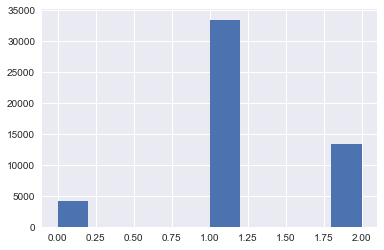

In [8]:
# frequency count of target classes
plt.hist(y_le)

In [9]:
# pickled for future use
pickle.dump(y_le, open("y_le.pkl", "wb"))

In [10]:
# omit features that were at the bottom of the feature importance list (based on intial random forest model)
omit_prefix = ["ExCoder", "AssessJob", "ImportantHiring", "CousinEducation", "EquipmentSatisfied",
              "Influence", "StackOverflow", "SurveyLong", "Questions", "InterestedAnswers", 
               "Salary", "ExpectedSalary", "JobProfile", "ResumeProfile", "LearnedHiring", "Company",
              "YearsCodedJobInt"]
omit = [col.startswith(tuple(omit_prefix)) for col in data_clean.columns]
omit_columns = data_clean.columns[omit]
keep_columns = [col for col in data_clean if col not in omit_columns]

In [11]:
# create clean and reduced features data frame for model fitting
X = data_clean[keep_columns]

In [12]:
# impute missing values with the feature's median value
X_imputed = pd.DataFrame(Imputer(missing_values='NaN', strategy='median', axis=0).fit_transform(X))

In [13]:
# scale all features
X_imputed_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_imputed))
X_imputed_scaled.columns = X.columns

In [14]:
# pickle data frame for future use
pickle.dump(X_imputed_scaled, open("X_imputed_scaled.pkl", "wb"))

### Model Fitting

For this project, I fit a number of different classification models (e.g., logistic regression, K Nearest Neighbors, and Random Forest). For models that had a better f1 and/or accuracy scores, I also tried to tune the hyperparameters. Since my AWS instance was having trouble with GridSearchCV, I used for loops to try out a range of hyperparameters to find the best one.

In [2]:
X_imputed_scaled = pickle.load(open("X_imputed_scaled.pkl", 'rb'))
y_le = pickle.load(open("y_le.pkl", 'rb'))

In [27]:
# proportion of each class
y_prop = np.unique(y_le, return_counts=True)[1]/sum(np.unique(y_le, return_counts=True)[1])
y_prop

array([ 0.08069322,  0.65644605,  0.26286073])

In [32]:
list(np.unique(y_le, return_counts=True)[1])

[4116, 33484, 13408]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed_scaled, y_le, stratify=y_le, test_size=0.3, random_state=4444)

#### Base Model

In [17]:
# predict that everyone pronounces GIF with a hard "g" (value of 1)
pred_constant = np.ones(y_le.shape)
confusion_matrix(y_le, pred_constant)

array([[    0,  4116,     0],
       [    0, 33484,     0],
       [    0, 13408,     0]])

In [34]:
# f1 (unweighted) and accuracy score
accuracy = sum(y_le == pred_constant)/len(pred_constant)
f1 = f1_score(y_le, y_pred, average="macro")

print(f"f1 score: {f1}")
print(f"accuracy score: {accuracy}")

f1 score: 0.389236983967729
accuracy score: 0.6564460476787954


In [20]:
# f1 (weighted), precision, and recall scores
print(classification_report(y_le, pred_constant, target_names=['With a hard "g," like "gift' , 'With a soft "g," like "jiff” ', 'Other']))

                               precision    recall  f1-score   support

  With a hard "g," like "gift       0.00      0.00      0.00      4116
With a soft "g," like "jiff”        0.66      1.00      0.79     33484
                        Other       0.00      0.00      0.00     13408

                  avg / total       0.43      0.66      0.52     51008



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Logistic Regression

In [3]:
# helper function to fit models
# def classification_metrics(X, y, classifier):
#     cross_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=4444)
#     acc_median = np.median(cross_val_score(classifier, X, y, cv=cross_validator, scoring='accuracy', n_jobs=2))
#     f1_median = np.median(cross_val_score(classifier, X, y, cv=cross_validator, scoring='f1_macro', n_jobs=2))
#     return f1_median, acc_median

def classification_metrics(X, y, classifier):
    cross_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=4444)
    y_pred = cross_val_predict(classifier, X_imputed_scaled, y_le, cv=cross_validator, n_jobs=2)
    f1 = f1_score(y_le, y_pred, average="macro")
    accuracy = sum(y_le==y_pred)/len(y_le)
    return y_pred, f1, accuracy
    
#     print(f'accuracy score: {accuracy}', )
#     print(classification_report(y_le, y_pred, target_names=['With a hard "g," like "gift' ,
#                                                             'With a soft "g," like "jiff” ', 'Other']))

In [12]:
# with minimal regularization penalty
lr = LogisticRegression(C=0.01)
y_pred, f1, accuracy = classification_metrics(X_imputed_scaled, y_le, lr)
print(f"f1: {f1}")
print(f"accuracy: {accuracy}")

f1: 0.3623424849203028
accuracy: 0.6808735884567126


#### Logistic Regression - Lasso

In [35]:
# try out different hyperparameter values for regularization starting from a large range and narrow down to find best one
alphas = [0.12] # based on previous searches
lasso_accuracy = []
lasso_f1 = []
    
for alpha in alphas[0:1]:
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.105)
    y_pred, f1, accuracy = classification_metrics(X_imputed_scaled, y_le, lasso)
    lasso_accuracy.append(accuracy)
    lasso_f1.append(f1)

zip_list = list(zip(alphas, lasso_f1, lasso_accuracy))
print(zip_list)

[(0.12, 0.36994790393498539, 0.68234394604767878)]


#### Logistic Regression with L2 Regularization (Ridge)

In [13]:
# try out different hyperparameter values for regularization starting from a large range and narrow down to find best one
alphas = [1.8]
ridge_accuracy = []
ridge_f1 = []

for alpha in alphas:
    ridge = LogisticRegression(penalty='l2', solver='liblinear', C=alpha)
    y_pred, f1, accuracy = classification_metrics(X_imputed_scaled, y_le, ridge)
    ridge_accuracy.append(accuracy)
    ridge_f1.append(f1)

zip_list = list(zip(alphas, ridge_f1, ridge_accuracy))
print(zip_list)

[(1.8, 0.38923698396772899, 0.681206869510665)]


In [14]:
# f1 (weighted), precision, and recall scores
print(classification_report(y_le, y_pred, target_names=['With a hard "g," like "gift' ,
                                                  'With a soft "g," like "jiff” ', 'Other']))

                               precision    recall  f1-score   support

  With a hard "g," like "gift       0.37      0.05      0.09      4116
With a soft "g," like "jiff”        0.70      0.96      0.81     33484
                        Other       0.51      0.18      0.27     13408

                  avg / total       0.63      0.68      0.61     51008



#### K Nearest Neighbours

In [38]:
# try out different hyperparameter values for n_neighbors starting from a large range and narrow down to find best one
neighbors = [18] # based on previous searches
knn_accuracy = []
knn_f1 = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    y_pred, f1, accuracy = classification_metrics(X_imputed_scaled, y_le, knn)
    knn_accuracy.append(accuracy)
    knn_f1.append(f1)

zip_list = list(zip(neighbors, knn_f1, knn_accuracy))
print(zip_list)


[(18, 0.32232250112084482, 0.65283877038895854)]


#### Decision Tree

In [40]:
classification_metrics(X_imputed_scaled, y_le, DecisionTreeClassifier())

(array([1, 1, 1, ..., 1, 2, 1]), 0.40341836775028844, 0.55812813676286077)

In [41]:
# f1 (weighted), precision, and recall scores
print(classification_report(y_le, y_pred, target_names=['With a hard "g," like "gift' ,
                                                  'With a soft "g," like "jiff” ', 'Other']))

                               precision    recall  f1-score   support

  With a hard "g," like "gift       0.27      0.02      0.04      4116
With a soft "g," like "jiff”        0.67      0.96      0.79     33484
                        Other       0.38      0.08      0.13     13408

                  avg / total       0.56      0.65      0.56     51008



#### Linear SVM

In [42]:
classification_metrics(X_imputed_scaled, y_le, LinearSVC())

(array([1, 1, 1, ..., 1, 1, 1]), 0.37365168154668443, 0.68234394604767878)

#### Random Forest

The random forest model turned out to have the best f1 score, although the accuracy score is slightly lower than the base model.

In [12]:
# try out different tuning parameter values and narrow down to find best one
# based on previous searches
leaf = [4]
maxfeatures = ["sqrt"]
crit = ["gini"]
n_est = [84]
rf_accuracy = []
rf_f1 = []
results = []

for c in crit:
    for mf in maxfeatures:
        for n in n_est:
            for p in leaf:
                rf = RandomForestClassifier(criterion=c, max_features=mf, n_estimators=n, min_samples_leaf=p, class_weight="balanced")
                y_pred, f1, accuracy = classification_metrics(X_imputed_scaled, y_le, rf)
                rf_accuracy.append(accuracy)
                rf_f1.append(f1)
                results.append([c, mf, n, p, f1, accuracy])

    print(results)

[['gini', 'sqrt', 84, 4, 0.4484522274780865, 0.64262468632371395]]


In [13]:
cm = confusion_matrix(y_le, y_pred)
cm

array([[ 1002,  1632,  1482],
       [ 1785, 28282,  3417],
       [ 1583,  8330,  3495]])

#### Important Features

In [18]:
rf.fit(X_imputed_scaled, y_le)
impt = list(zip(data_clean.columns, rf.feature_importances_))
sorted(impt,key = lambda item: item[1], reverse=True)

[('IDE_Komodo', 0.033604911299771931),
 ('YearsProgramInt', 0.032826200203136424),
 ('NativeEnglish', 0.017613211013526149),
 ('BuildingThings_Somewhat agree', 0.0124299335472509),
 ('YearsCodedJobInt', 0.011142428095903502),
 ('Methodology_Evidence-based SWE', 0.010378076303040341),
 ('HaveWorkedPlatform_counts', 0.0089208028403796134),
 ('EducationTypes_counts', 0.0088363854503249809),
 ('WantWorkPlatform_counts', 0.0086530057486799185),
 ('SelfTaughtTypes_counts', 0.0084429031907262732),
 ('ImportantBenefits_counts', 0.0083154491365975778),
 ('WorkStartInt', 0.008300652716973219),
 ('WantWorkDatabase_counts', 0.0079208655535478335),
 ('JobProfile_counts', 0.0074574033261342928),
 ('HaveWorkedDatabase_counts', 0.006467517081052968),
 ('MetricAssess_Commit frequency', 0.0062777385450907301),
 ('WantWorkFramework_counts', 0.0057461670089106734),
 ('Methodology_Domain-driven design', 0.0057007613379279334),
 ('ExCoderWillNotCode_Disagree', 0.0055197074898176201),
 ('MobileDeveloperType_